In [ ]:
# Copyright 2020 NVIDIA Corporation. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# NVTabular demo on Outbrain Data

## Overview

In this notebook we train TF Wide & Deep Learning framework using [Kaggle Outbrain dataset](https://www.kaggle.com/c/outbrain-click-prediction). In that competition, ‘Kagglers’ were challenged to predict on which ads and other forms of sponsored content its global users would click. One of  the top finishers' preprocessing and feature engineering pipeline is taken into consideration here, and this pipeline was restructured using NVTabular and cuDF. The Kaggle Outbrain click prediction challenge datasets can be downloaded from [here](https://www.kaggle.com/c/outbrain-click-prediction/data).

[Wide & Deep Learning](https://ai.googleblog.com/2016/06/wide-deep-learning-better-together-with.html) refers to a class of networks that use the output of two parts working in parallel - wide model and deep model - to make predictions using categorical and continuous inputs. The wide model is a generalized linear model of features together with their transforms. The deep model in this notebook is a series of three hidden MLP layers of [1024, 512, 256] neurons each beginning with a dense embedding of features. 

In [2]:
import os
import glob
import time
import datetime
import math
import graphviz

import cupy
import cudf
import rmm
from numba import cuda
import numpy as np

import nvtabular as nvt
from nvtabular.io import Shuffle
from nvtabular.ops import Normalize, FillMedian, FillMissing, Categorify, LogOp, JoinExternal, Dropna, LambdaOp, JoinGroupby, HashBucket, TargetEncoding, get_embedding_sizes, Rename
from nvtabular.ops.column_similarity import ColumnSimilarity

from nvtabular import ColumnGroup

First, we set where the dataset should be saved once processed (OUTPUT_BUCKET_FOLDER), as well as where the dataset originally resides (DATA_BUCKET_FOLDER).

In [3]:
OUTPUT_BUCKET_FOLDER = os.environ.get("OUTPUT_DATA_DIR", "./preprocessed/")
DATA_BUCKET_FOLDER = os.environ.get("INPUT_DATA_DIR", "/datasets/outbrain/")

## Preparing Our Dataset

Here, we merge the component tables of our dataset into a single data frame, using [cuDF](https://github.com/rapidsai/cudf), which is a GPU DataFrame library for loading, joining, aggregating, filtering, and otherwise manipulating data. We do this because NVTabular applies a workflow to a single table. We also re-initialize managed memory. `rmm.reinitialize()` provides an easy way to initialize RMM (RAPIDS Memory Manager) with specific memory resource options across multiple devices. The reason we re-initialize managed memory here is to allow us to perform memory intensive merge operation. Note that dask-cudf can also be used here.

In [4]:
from cudf import read_csv

# use managed memory for device memory allocation
rmm.reinitialize(managed_memory=True)  

# Merge all the CSV files together
documents_meta = read_csv(DATA_BUCKET_FOLDER + 'documents_meta.csv', na_values=['\\N', ''])
merged = (read_csv(DATA_BUCKET_FOLDER+'clicks_train.csv', na_values=['\\N', ''])
             .merge(read_csv(DATA_BUCKET_FOLDER + 'events.csv', na_values=['\\N', '']), on="display_id", how="left", suffixes=('', '_event'))
             .merge(read_csv(DATA_BUCKET_FOLDER+'promoted_content.csv', na_values=['\\N', '']), on="ad_id", how="left", suffixes=('', '_promo'))
             .merge(documents_meta, on="document_id", how="left")
             .merge(documents_meta, left_on="document_id_promo", right_on="document_id", how="left", suffixes=('', "_promo")))

Let's create the output directories to store the preprocessed parquet files.

In [5]:
output_train_dir = os.path.join(OUTPUT_BUCKET_FOLDER, 'train/')
output_valid_dir = os.path.join(OUTPUT_BUCKET_FOLDER, 'valid/')
! mkdir -p $output_train_dir
! mkdir -p $output_valid_dir

We use a time-stratified sample to create a validation set that is more recent, and save both our train and validation sets to parquet files to be read by NVTabular. Note that you should run the cell below only once, then save your `train` and `valid` data frames as parquet files. If you want to rerun the entire notebook, do not run this cell again to get consistent results, otherwise you might end up with a different train-validation split each time.

In [6]:
# Do a stratified split of the merged dataset into a training/validation dataset
merged['day_event'] = (merged['timestamp'] / 1000 / 60 / 60 / 24).astype(int)
random_state = cudf.Series(cupy.random.uniform(size=len(merged)))
valid_set, train_set = merged.scatter_by_map(((merged.day_event <= 10) & (random_state > 0.2)).astype(int)) 

train_filename = os.path.join(OUTPUT_BUCKET_FOLDER, "train_gdf.parquet")
valid_filename = os.path.join(OUTPUT_BUCKET_FOLDER, "valid_gdf.parquet")
train_set.to_parquet(train_filename, compression=None)
valid_set.to_parquet(valid_filename, compression=None)
merged = train_set = valid_set= None

In [7]:
rmm.reinitialize(managed_memory=False) 

We read in three more cudf data frames, <i>documents categories</i>, <i>topics</i>, and <i>entities</i>, and use them to create sparse matricies in cupy. We will use these later to calculate cosine similarity between event document (landing page context) and ad document profile vectors (TF-IDF), i.e., how close in profile an ad is to the page that it is being displayed.

In [8]:
documents_categories_cudf = cudf.read_csv(DATA_BUCKET_FOLDER + 'documents_categories.csv')
documents_topics_cudf = cudf.read_csv(DATA_BUCKET_FOLDER + 'documents_topics.csv')
documents_entities_cudf = cudf.read_csv(DATA_BUCKET_FOLDER + 'documents_entities.csv')
# read in document categories/topics/entities as cupy sparse matrices
def df_to_coo(df, row="document_id", col=None, data="confidence_level"):
    return cupy.sparse.coo_matrix((df[data].values, (df[row].values, df[col].values)))

categories = df_to_coo(documents_categories_cudf, col="category_id")
topics = df_to_coo(documents_topics_cudf, col="topic_id")
documents_entities_cudf['entity_id'] = documents_entities_cudf['entity_id'].astype("category").cat.codes
entities = df_to_coo(documents_entities_cudf, col="entity_id")

documents_categories_cudf = documents_topics_cudf = documents_entities_cudf =  None

Below, we create a custom operator that calculates the time difference between a specified time column (either publish_time or publish_time_promo) and timestamp. This is used to calculate <i>time elapsed since publication</i> between the landing page and the ad.

In [9]:
#To save disk space, the timestamps in the entire dataset are relative to the first time in the dataset. 
#To recover the actual epoch time of the visit, we add 1465876799998 to the timestamp.
TIMESTAMP_DELTA = 1465876799998

from nvtabular.ops import Operator

class DaysSincePublished(Operator):
    def transform(self, columns, gdf):
        for column in columns:
            col = gdf[column]
            col.loc[col == ""] = None
            col = col.astype('datetime64[ns]')
            timestamp = (gdf['timestamp']+TIMESTAMP_DELTA).astype('datetime64[ms]')
            delta = (timestamp - col).dt.days
            gdf[column + "_since_published"] = delta * (delta >=0) * (delta<=10*365)
        return gdf
            
    def output_column_names(self, columns):
        return [column + "_since_published" for column in columns]
            
    def dependencies(self):
        return ["timestamp"]

## Initiate NVTabular Workflow

Now that our datasets, sparse matrices and udf are created, we can begin laying the groundwork for NVTabular. NVTabular requires input features to be defined as groups of columns , so we define our ColumnGroup features at this step. Note that feature engineering and preprocessing often happens to sets of columns, so we adopt that method and require the user to specify continuous and categoricals along with the target as lists within ColumnGroup.

At this point, our data still isn’t in a form that’s ideal for consumption by our W&D model. There are missing values, and our categorical variables are still represented by random, discrete identifiers, and need to be transformed into contiguous indices for embedding lookups. The distributions of our continuous variables are uncentered. We also would like to create new features that will help to increase the model accuracy.

Let's begin to create and process features using NVTabular ops:
 * <i>geo_location_state</i> and <i>geo_location_country</i> are created by stripping geo_location using the `LambdaOp`
 * <i>publish_time_days_since_published</i> and <i>publish_time_promo_days_since_published</i> features are created using the `calculate_delta` function in a `LambdaOp`
 * Missing values are filled using median value depending on the feature using `FillMedian()`op
 * Continuous features are log transformed with the `LogOp()`.
 
`Categorify` op is used for categorification, i.e. encoding of categorical features. Categorify op takes a param called `freq_threshold` which is used for frequency capping. This handy functionality will map all categories which occur in the dataset with some threshold level of infrequency to the _same_ index, keeping the model from overfitting to sparse signals. We don't apply  frequency thresholds in this example, but one can easily create a frequency threshold dictionary, assign a custom threshold value for each categorical feature, and feed that dictionary into the `Categorify` op as `freq_threshold` param.

One of the important part of building recommender systems is to do feature engineering. As a very promising feature engineering technique, `Target Encoding` processes the categorical features and makes them easier accessible to the model during training and validation. *Target Encoding (TE)* has emerged as being both effective and efficient in many data science projects. For example, it is the major component of Nvidia Kaggle Grandmasters team’s [winning solution](https://medium.com/rapids-ai/winning-solution-of-recsys2020-challenge-gpu-accelerated-feature-engineering-and-training-for-cd67c5a87b1f) of [Recsys Challenge 2020](http://www.recsyschallenge.com/2020/). TE calculates the statistics from a target variable grouped by the unique values of one or more categorical features. For example in a binary classification problem, it calculates the probability that the target is true for each category value - a simple mean. In other words, for each distinct element in feature <b>$x$</b> we are going to compute the average of the corresponding values in target <i>y</i>. Then we are going to replace each $x_{i}$ with the corresponding mean value. For more details on TargetEncoding please visit [here](https://medium.com/rapids-ai/target-encoding-with-rapids-cuml-do-more-with-your-categorical-data-8c762c79e784) and [here](https://github.com/rapidsai/deeplearning/blob/main/RecSys2020Tutorial/03_3_TargetEncoding.ipynb).

Here, we apply Target Encoding to certain categorical features with *kfold* of 5 and *smoothing* of 20 to avoid overfitting using [TargetEncoding op](https://github.com/NVIDIA/NVTabular/blob/a0141d0a710698470160bc2cbc42b18ce2d49133/nvtabular/ops/target_encoding.py).

## Feature Engineering

In [10]:
# geo processing: apply two different lambda operators to the ‘geo_location’ column, and 
# extract the country/state from the geo_location value. The geo_location column
# looks something like "US>CA>12345", so we're using string slicing to pull out the country
# and the country+state then 
geo_location = ColumnGroup(["geo_location"])
country = geo_location >> (lambda col: col.str.slice(0, 2)) >> Rename(postfix="_country")
state = geo_location >> (lambda col: col.str.slice(0, 5)) >> Rename(postfix="_state")
geo_features = geo_location + country + state

# categoricals processing: categorify certain input columns as well as the geo features
cats = ColumnGroup(['ad_id', 'document_id', 'platform', 'document_id_promo', 'campaign_id', 'advertiser_id', 'source_id', 'publisher_id', 'source_id_promo', 'publisher_id_promo'])
cat_features = geo_features + cats >> Categorify()

# Apply TargetEncoding to certain categoricals with kfold of 1 and smoothing of 20
te_features = cats >> TargetEncoding("clicked", kfold=5, p_smooth=20)
 
# process dates using the ‘DaysSincePublished’ custom operator
dates = ["publish_time", "publish_time_promo"]
date_features = dates >> DaysSincePublished() >> FillMedian() >> LogOp()

Let's visualize our calculation graph with the column groups we used and created so far.

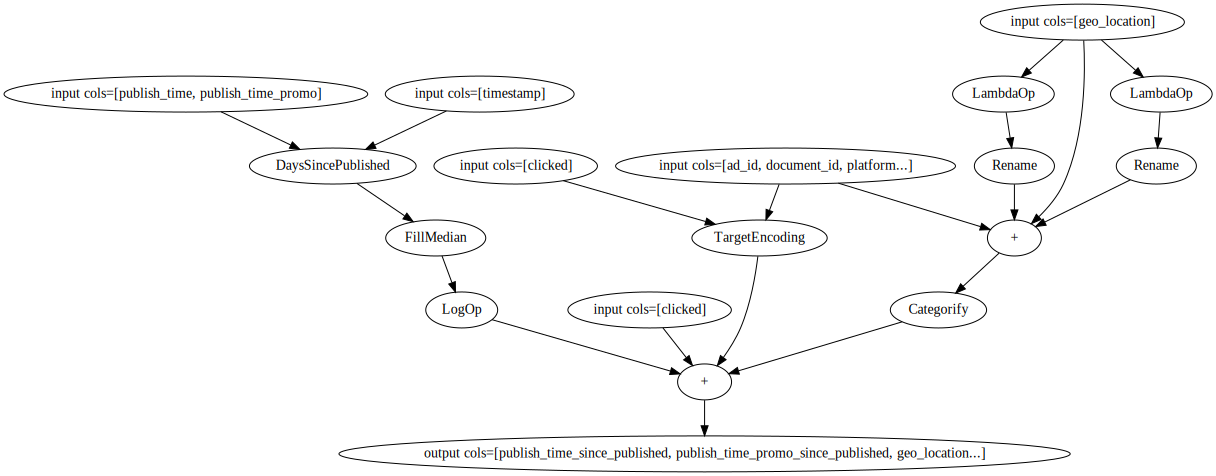

In [11]:
features = date_features + cat_features + te_features + "clicked"
features.graph

A user might sometimes be interested to continue reading about the same topics of the current page. Computing the similarity between the textual content of the current page and the pages linked to the displayed ads, can be a relevant feature for a model that predicts which ad the user would click next. A simple, yet effective way to compute the similarity between documents is generating the TF-IDF vectors for each of them, which captures their most relevant terms, and then computing the cosine similarity between those vectors.
 
Below, we calculate <i>doc_event_doc_ad_sim_categories</i>, <i>topics</i>, and <i>entities</i> using the `ColumnSimilarity` op, which utilizes the sparse categories, topics, and entities matrices that were created above to calculate landing page similarity for categories, topics, and entities. We calculate Cosine similarity between event doc (landing page) and ad doc aspects vectors (TF-IDF). Creating these extra features help to improve model accuracy and predictability. 

Note that we rename the column names to avoid duplicated column names.

In [12]:
sim_features_categ = [["document_id", "document_id_promo"]] >> ColumnSimilarity(categories, metric='tfidf', on_device=False) >> Rename(postfix="_categories")
sim_features_topics= [["document_id", "document_id_promo"]] >> ColumnSimilarity(topics, metric='tfidf', on_device=False) >> Rename(postfix="_topics")
sim_features_entities= [["document_id", "document_id_promo"]] >> ColumnSimilarity(entities, metric='tfidf', on_device=False) >> Rename(postfix="_entities")
sim_features = sim_features_categ + sim_features_topics +  sim_features_entities

/rapids/notebooks/benf/NVTabular/nvtabular/ops/column_similarity.py:226: RuntimeWarning: divide by zero encountered in true_divide
  idf = np.log(N / np.bincount(X.col))


In [13]:
# The workflow is created with the output node of the graph
workflow = nvt.Workflow(features + sim_features)

We then create an NVTabular Dataset object both for train and validation sets. We calculate statistics for this workflow on the input dataset, i.e. on our training set, using the `workflow.fit()` method so that our <i>Workflow</i> can use these stats to transform any given input. When our <i>Workflow</i> transorms our datasets and, we also save the results out to parquet files for fast reading at train time.

In [14]:
train_dataset = nvt.Dataset(train_filename)
valid_dataset = nvt.Dataset(valid_filename)

# Calculate statistics on the training set
workflow.fit(train_dataset)

In [15]:
# use the calculated statistics to transform the train/valid datasets 
# and write out each as parquet
workflow.transform(train_dataset).to_parquet(output_path=output_train_dir, shuffle=Shuffle.PER_PARTITION, out_files_per_proc=5)
workflow.transform(valid_dataset).to_parquet(output_path=output_valid_dir)

We can save the stats from the workflow and load it anytime, so we can run training without doing preprocessing.

EMBEDDING_TABLE_SHAPES defines the size of the embedding tables that our model will use to map categorical outputs from NVTabular into numeric dense inputs.

In [16]:
from nvtabular.ops import get_embedding_sizes

EMBEDDING_TABLE_SHAPES = {column: (shape[0], min(shape[1], 16)) for column, shape in get_embedding_sizes(workflow).items()}
EMBEDDING_TABLE_SHAPES

{'ad_id': (418340, 16),
 'advertiser_id': (4053, 16),
 'campaign_id': (31360, 16),
 'document_id': (693449, 16),
 'document_id_promo': (144011, 16),
 'geo_location': (2885, 16),
 'geo_location_country': (232, 16),
 'geo_location_state': (2485, 16),
 'platform': (5, 16),
 'publisher_id': (483, 16),
 'publisher_id_promo': (811, 16),
 'source_id': (4739, 16),
 'source_id_promo': (6816, 16)}

We select define categorical and numerical features that are processed and generated via the NVTabular workflow to train our W&D TF model.

In [17]:
CATEGORICAL_COLUMNS =['geo_location', 'geo_location_country', 'geo_location_state', 'ad_id','document_id', 'platform', 'document_id_promo', 
                      'campaign_id','advertiser_id', 'source_id', 'publisher_id', 'source_id_promo', 'publisher_id_promo']

In [18]:
NUMERIC_COLUMNS = ['document_id_document_id_promo_sim_categories',
'document_id_document_id_promo_sim_topics',
'document_id_document_id_promo_sim_entities',
'publish_time_since_published', 
'publish_time_promo_since_published',
'TE_ad_id_clicked',
'TE_document_id_promo_clicked', 
'TE_campaign_id_clicked',
'TE_advertiser_id_clicked', 
'TE_source_id_clicked',
'TE_publisher_id_clicked',
]

## Training a TF W&D Model

In [19]:
import tensorflow as tf

# we can control how much memory to give tensorflow with this environment variable
# IMPORTANT: make sure you do this before you initialize TF's runtime, otherwise
# TF will have claimed all free GPU memory
#os.environ['TF_MEMORY_ALLOCATION'] = "0.8" # fraction of free memory
from tensorflow.keras.mixed_precision import experimental as mixed_precision
from tensorflow.python.feature_column import feature_column_v2 as fc

from nvtabular.loader.tensorflow import KerasSequenceLoader, KerasSequenceValidater
from nvtabular.framework_utils.tensorflow import layers

We create tensorflow feature columns corresponding to each feature of the model input. If you're using NVTabular with TensorFlow feature_columns, you should only be using `tf.feature_column.categorical_column_with_identity` for categorical features, since any other transformation (categorification and/or hashing) should be handled in NVTabular on the GPU. This feature column is passed to the wide portion of the model. If a categorical column corresponds to an embedding table, it is wrapped with an embedding_column feature_column, if it does not correspond to an embedding table, it is wrapped as an indicator column. The wrapped column is passed to the deep portion of the model. Continuous columns are passed to both the wide and deep portions of the model after being encapsulated as a `numeric_column`.

In [20]:
def get_feature_columns():
    wide_columns, deep_columns = [], []

    for column_name in CATEGORICAL_COLUMNS:
        if column_name in EMBEDDING_TABLE_SHAPES: # Changing hashing to identity + adding modulo to dataloader
            categorical_column = tf.feature_column.categorical_column_with_identity(
                column_name, num_buckets=EMBEDDING_TABLE_SHAPES[column_name][0])
        else:
            raise ValueError(f'Unexpected categorical column found {column_name}')

        if column_name in EMBEDDING_TABLE_SHAPES:
            wrapped_column = tf.feature_column.embedding_column(
                categorical_column,
                dimension=EMBEDDING_TABLE_SHAPES[column_name][1],
                combiner='mean')
        else:
            wrapped_column = tf.feature_column.indicator_column(categorical_column)
            
        wide_columns.append(categorical_column)
        deep_columns.append(wrapped_column)
    
    numerics = [tf.feature_column.numeric_column(column_name, shape=(1,),dtype=tf.float32) 
                for column_name in NUMERIC_COLUMNS]
    
    wide_columns.extend(numerics)
    deep_columns.extend(numerics)
       
    return wide_columns, deep_columns

Next, we define the layer shape and dropout probability for the deep portion of the model.

In [21]:
deep_hidden_units=[1024, 512, 256]
deep_dropout=.1

An input is created for each feature column, with a datatype of either tf.float32 for continuous values, or tf.int32 for categorical values. To implement the wide model, for categorical inputs, we embed them to a dimension of one, and sum them with the results of applying a dense layer with output dimension one, effectively weighting and summing each of the inputs. For the deep model, we embed our categorical columns according to the feature columns we defined earlier, and concatenate the newly dense features with our dense continuous features, which we pass to our deep model, which by default is a 5 layer MLP with internal dimension of 1024 neurons for each layer. 

In [22]:
wide_columns, deep_columns = get_feature_columns()

wide_weighted_outputs = []  # a list of (batch_size, 1) contributors to the linear weighted sum
numeric_dense_inputs = []  # NumericColumn inputs; to be concatenated and then fed to a dense layer
wide_columns_dict = {}  # key : column
deep_columns_dict = {}  # key : column
features = {}  # tf.keras.Input placeholders for each feature to be used

# construct input placeholders for wide features
for col in wide_columns:
    features[col.key] = tf.keras.Input(shape=(1,),
                                       batch_size=None, 
                                       name=col.key,
                                       dtype=tf.float32 if col.key in NUMERIC_COLUMNS else tf.int32,
                                       sparse=False)
    wide_columns_dict[col.key] = col
for col in deep_columns:
    is_embedding_column = ('key' not in dir(col))
    key = col.categorical_column.key if is_embedding_column else col.key

    if key not in features:
        features[key] = tf.keras.Input(shape=(1,), 
                                       batch_size=None, 
                                       name=key, 
                                       dtype=tf.float32 if col.key in NUMERIC_COLUMNS else tf.int32,
                                       sparse=False)
    deep_columns_dict[key] = col

for key in wide_columns_dict:
    if key in EMBEDDING_TABLE_SHAPES: 
        wide_weighted_outputs.append(tf.keras.layers.Flatten()(tf.keras.layers.Embedding(
            EMBEDDING_TABLE_SHAPES[key][0], 1, input_length=1)(features[key])))
    else:
        numeric_dense_inputs.append(features[key])

categorical_output_contrib = tf.keras.layers.add(wide_weighted_outputs,
                                                 name='categorical_output')
numeric_dense_tensor = tf.keras.layers.concatenate(
    numeric_dense_inputs, name='numeric_dense')
deep_columns = list(deep_columns_dict.values())

dnn = layers.DenseFeatures(deep_columns, name='deep_embedded')(features)
for unit_size in deep_hidden_units:
    dnn = tf.keras.layers.Dense(units=unit_size,activation='relu')(dnn)
    dnn = tf.keras.layers.Dropout(rate=deep_dropout)(dnn)
    dnn = tf.keras.layers.BatchNormalization(momentum=.999)(dnn)
dnn = tf.keras.layers.Dense(units=1)(dnn)
dnn_model = tf.keras.Model(inputs=features,
                           outputs=dnn)
linear_output = categorical_output_contrib + tf.keras.layers.Dense(1)(numeric_dense_tensor)

linear_model = tf.keras.Model(inputs=features,
                              outputs=linear_output)

wide_and_deep_model = tf.keras.experimental.WideDeepModel(
    linear_model, dnn_model, activation='sigmoid')

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


We define the datasets that will be used to ingest data into our model. In this case, the NVTabular dataloaders take a set of parquet files generated by NVTabular as input, and are capable of accelerated throughput. The [KerasSequenceLoader](https://github.com/NVIDIA/NVTabular/blob/9aa70caa1dfb5d2fd694cad535def1e470d37b29/nvtabular/loader/tensorflow.py#L89) manages shuffling by loading in chunks of data from different parts of the full dataset, concatenating them and then shuffling, then iterating through this super-chunk sequentially in batches. The number of "parts" of the dataset that get sample, or "partitions", is controlled by the <i>parts_per_chunk</i> parameter, while the size of each one of these parts is controlled by the <i>buffer_size</i> parameter, which refers to a fraction of available GPU memory. Using more chunks leads to better randomness, especially at the epoch level where physically disparate samples can be brought into the same batch, but can impact throughput if you use too many.

The validation process gets slightly complicated by the fact that <i>model.fit</i> doesn't accept Keras Sequence objects as validation data. To support this, we also define a [KerasSequenceValidater](https://github.com/NVIDIA/NVTabular/blob/9aa70caa1dfb5d2fd694cad535def1e470d37b29/nvtabular/loader/tensorflow.py#L351), a lightweight Keras callback to handle validation.

Now that our data is preprocessed and saved out, we can leverage datasets to read through the preprocessed parquet files in an online fashion to train neural networks.

In [23]:
TRAIN_PATHS = sorted(glob.glob('./preprocessed/train/*.parquet'))
VALID_PATHS = sorted(glob.glob('./preprocessed/valid/*.parquet'))

In [24]:
train_dataset_tf = KerasSequenceLoader(
    TRAIN_PATHS, # you could also use a glob pattern
    batch_size=131072,
    label_names=['clicked'],
    cat_names=CATEGORICAL_COLUMNS,
    cont_names=NUMERIC_COLUMNS,
    engine='parquet',
    shuffle=True,
    buffer_size=0.06, # how many batches to load at once
    parts_per_chunk=1
)

valid_dataset_tf = KerasSequenceLoader(
    VALID_PATHS, # you could also use a glob pattern
    batch_size=131072,
    label_names=['clicked'],
    cat_names=CATEGORICAL_COLUMNS,
    cont_names=NUMERIC_COLUMNS,
    engine='parquet',
    shuffle=False,
    buffer_size=0.06,
    parts_per_chunk=1
)
validation_callback = KerasSequenceValidater(valid_dataset_tf)

The wide portion of the model is optimized using the <i>Follow The Regularized Leader (FTRL)</i> algorithm, while the deep portion of the model is optimized using <i>Adam</i> optimizer.

In [25]:
wide_optimizer = tf.keras.optimizers.Ftrl(
        learning_rate=0.1,
)

deep_optimizer = tf.keras.optimizers.Adam(
        learning_rate=0.2
) 

Finally, we compile our model with our dual optimizers and binary cross-entropy loss, and train our model for 10 epochs.

In [ ]:
wide_and_deep_model.compile(
    optimizer=[wide_optimizer, deep_optimizer],
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.AUC()],
    experimental_run_tf_function=False
)
history = wide_and_deep_model.fit(train_dataset_tf, callbacks=[validation_callback], epochs=10)